# Пиксельная визуализация: нарушения ПДД в Москве

**Цель:** рассмотреть способ создания пиксельной визуализации крупных массивов данных, не имея четких гайдлайнов и используя средства Портала открытых данных г. Москва

**Вдохновение:** [«Pixel-based visualization of traffic data»](https://social-glass.tudelft.nl/visualising-traffic-data/)

**Данные:** «Нарушения ПДД, выявляемые с использованием автоматизированной системы фотовидеофиксации нарушений правил дорожного движения интеллектуальной транспортной системы города Москвы» ([ссылка](https://data.mos.ru/opendata/7704786030-narusheniya-pdd-vyyavlyaemye-s-ispolzovaniem-avtomaticheskoy-sistemy-fotovideofiksatsii-narusheniy-pdd/data/table?versionNumber=3&releaseNumber=56))

![Pixel-based visualization](https://social-glass.tudelft.nl/wp-content/uploads/traffic_plot_plasma.png)

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Чистка данных

In [112]:
with open('/Users/ivanskv/Documents/GitHub/moscow-infringements/data.csv', 'r') as f:
  d = pd.read_csv(f, sep = ';')

d.drop('Unnamed: 13', axis = 1, inplace = True)

In [113]:
d.head()

,ID,ReportDate,TotalInfringementsAmount,global_id,SpeedLimitInfringementsAmount,BusLaneOffenceAmount,TTKOffenceAmount,ParkingOffenceAmount,FormalizedTotalInfringements,FormalizedSpeedLimitInfringementsAmount,FormalizedBusLaneOffenceAmount,FormalizedTTKOffenceAmount,FormalizedParkingOffenceAmount
0,20,20.01.2013,5374,1726857,2953,0,0,1789,2440,2105,0,0,335
1,21,21.01.2013,25312,1726858,560,18851,0,4709,1551,317,50,0,1184
2,22,22.01.2013,29132,1726859,1153,20724,0,5976,2672,659,609,0,1404
3,23,23.01.2013,27909,1726860,1489,18786,0,6380,4061,1031,1064,0,1966
4,24,24.01.2013,29952,1726861,1239,19982,0,7436,2952,561,534,0,1857


Конвертируем строковый признак `ReportDate` в формат **timestamp**, а также исключаем незаконченный (на момент написания данного скрипта) 2020 год:

In [114]:
d.ReportDate = pd.to_datetime(d.ReportDate, format = "%d.%m.%Y")
d = d[d.ReportDate.dt.year != 2020]

На всякий случай проверим соответствие `TotalInfringementsAmount` сумме `SpeedLimitInfringementsAmount`, `BusLaneOffenceAmount`, `TTKOffenceAmount` и `ParkingOffenceAmount`.

In [115]:
errors = np.where(d.TotalInfringementsAmount != d.SpeedLimitInfringementsAmount + d.BusLaneOffenceAmount + d.TTKOffenceAmount + d.ParkingOffenceAmount)[0]
errors

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   25,   26,
         30,   31,   32,   33,   34,   35,   36,   37,   38,   39,   40,
         41,   42,   43,   44,   45,   46,   47,   48,   49,   52,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  164,  165,  166,  167,  168,  169,  170,  171,  172,
        173,  174,  175,  176,  177,  178,  179,  1

Такое расположение «неверных» значений общего числа правонарушений наталкивает на мысль о наличии систематических ошибок в данных. Для ощущения масштаба трагедии построим scatter plot для суммы подкатегорий правонарушений и их общего количества:

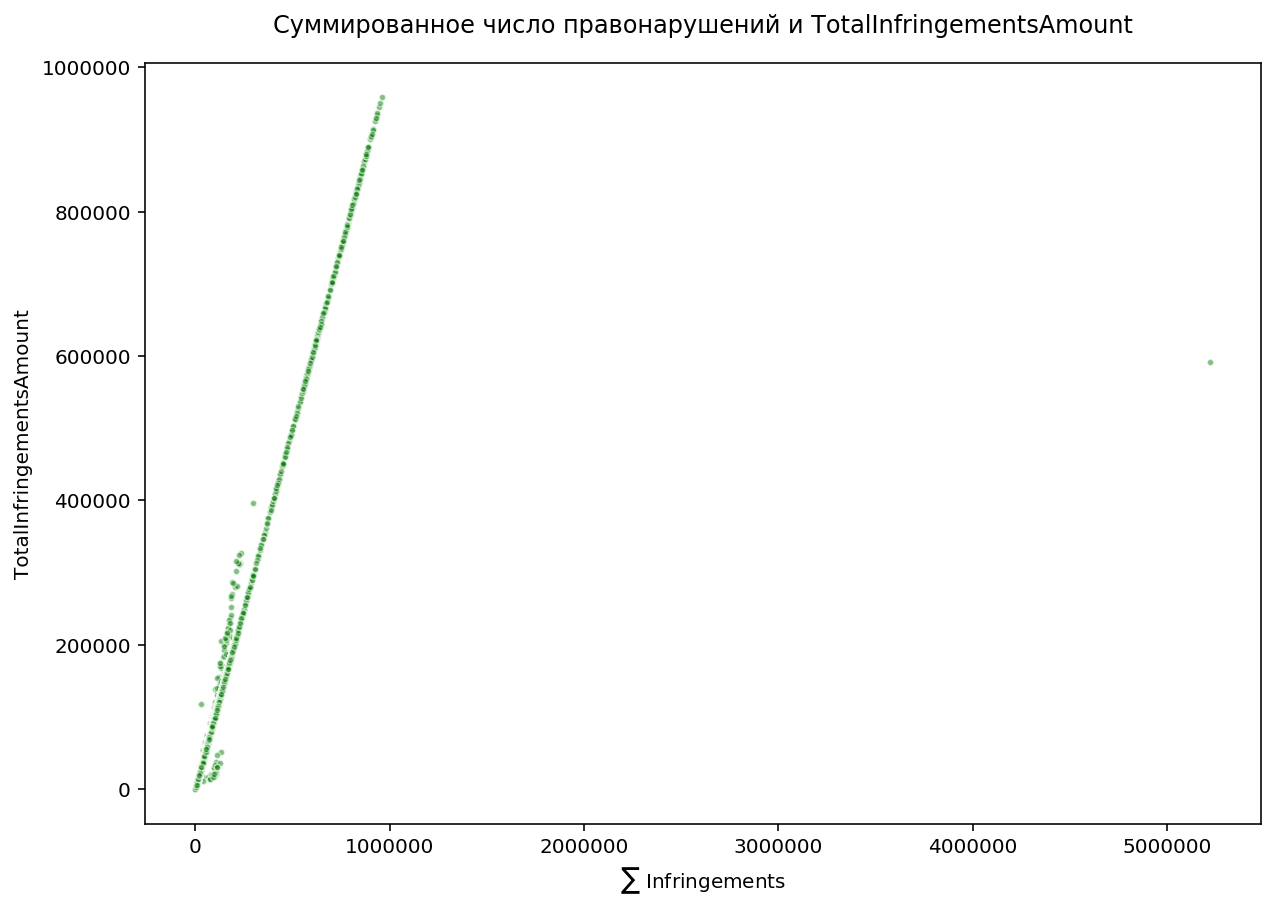

In [116]:
fig = plt.figure(figsize = (10, 7))

sns.scatterplot(d.SpeedLimitInfringementsAmount + d.BusLaneOffenceAmount + d.TTKOffenceAmount + d.ParkingOffenceAmount, d.TotalInfringementsAmount, s = 10, color = 'green', alpha = 0.5)

plt.title('Суммированное число правонарушений и TotalInfringementsAmount', pad = 15)
plt.xlabel('$\sum$ Infringements')

plt.show()

Сразу видно, что крайняя правая точка на графике соответствует ошибке в одной из **просуммированных** переменных. Найдем индекс этого наблюдения и проверим его содержимое:

In [117]:
print(np.argmax(d.SpeedLimitInfringementsAmount + d.BusLaneOffenceAmount + d.TTKOffenceAmount + d.ParkingOffenceAmount))
d.iloc[1944]

1944


ID                                                        1945
ReportDate                                 2018-05-28 00:00:00
TotalInfringementsAmount                                591226
global_id                                            864831181
SpeedLimitInfringementsAmount                            66148
BusLaneOffenceAmount                                   5144697
TTKOffenceAmount                                          1571
ParkingOffenceAmount                                      8810
FormalizedTotalInfringements                             49155
FormalizedSpeedLimitInfringementsAmount                  41513
FormalizedBusLaneOffenceAmount                               2
FormalizedTTKOffenceAmount                                   0
FormalizedParkingOffenceAmount                            7640
Name: 1944, dtype: object

Из общей массы выбивается значение `BusLaneOffenceAmount`. Вероятно, оно вызвано опечаткой: значению была приписана лишняя четверка. Исправим эту проблему.

In [118]:
d.BusLaneOffenceAmount.iloc[1944] = 514697

Построим график снова:

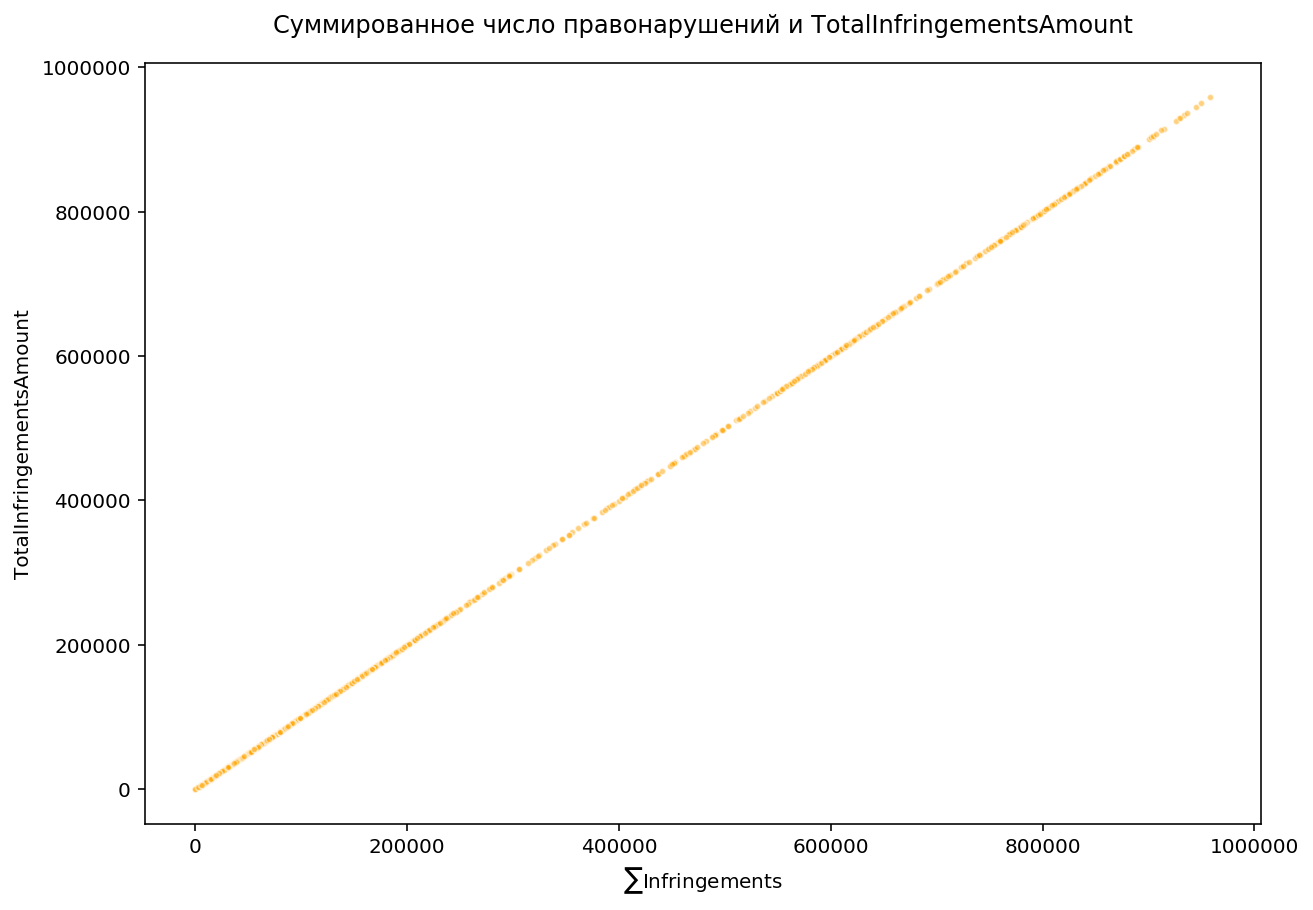

In [148]:
fig = plt.figure(figsize = (10, 7))

sns.scatterplot(d.SpeedLimitInfringementsAmount + d.BusLaneOffenceAmount + d.TTKOffenceAmount + d.ParkingOffenceAmount, d.TotalInfringementsAmount, s = 10, color = 'orange', alpha = 0.5)

plt.title('Суммированное число правонарушений и TotalInfringementsAmount', pad = 15)
plt.xlabel('$\sum$Infringements')

plt.show()

Очевидно, бессмысленно разбирать каждый из ошибочных случаев в отдельности. Поскольку отклонения проблемных наблюдений от линейного тренда в целом несущественны, примем за норму считать сумму подкатегорий правонарушений за истинное значение их общего числа.

In [120]:
d.TotalInfringementsAmount = d.SpeedLimitInfringementsAmount + d.BusLaneOffenceAmount + d.TTKOffenceAmount + d.ParkingOffenceAmount

Убедимся, что все проблемные наблюдения исчезли:

In [121]:
np.sum(np.where(d.TotalInfringementsAmount != d.SpeedLimitInfringementsAmount + d.BusLaneOffenceAmount + d.TTKOffenceAmount + d.ParkingOffenceAmount)) == 0

True

Дополнительно можно посмотреть на временное распределение числа встреченных ошибок.

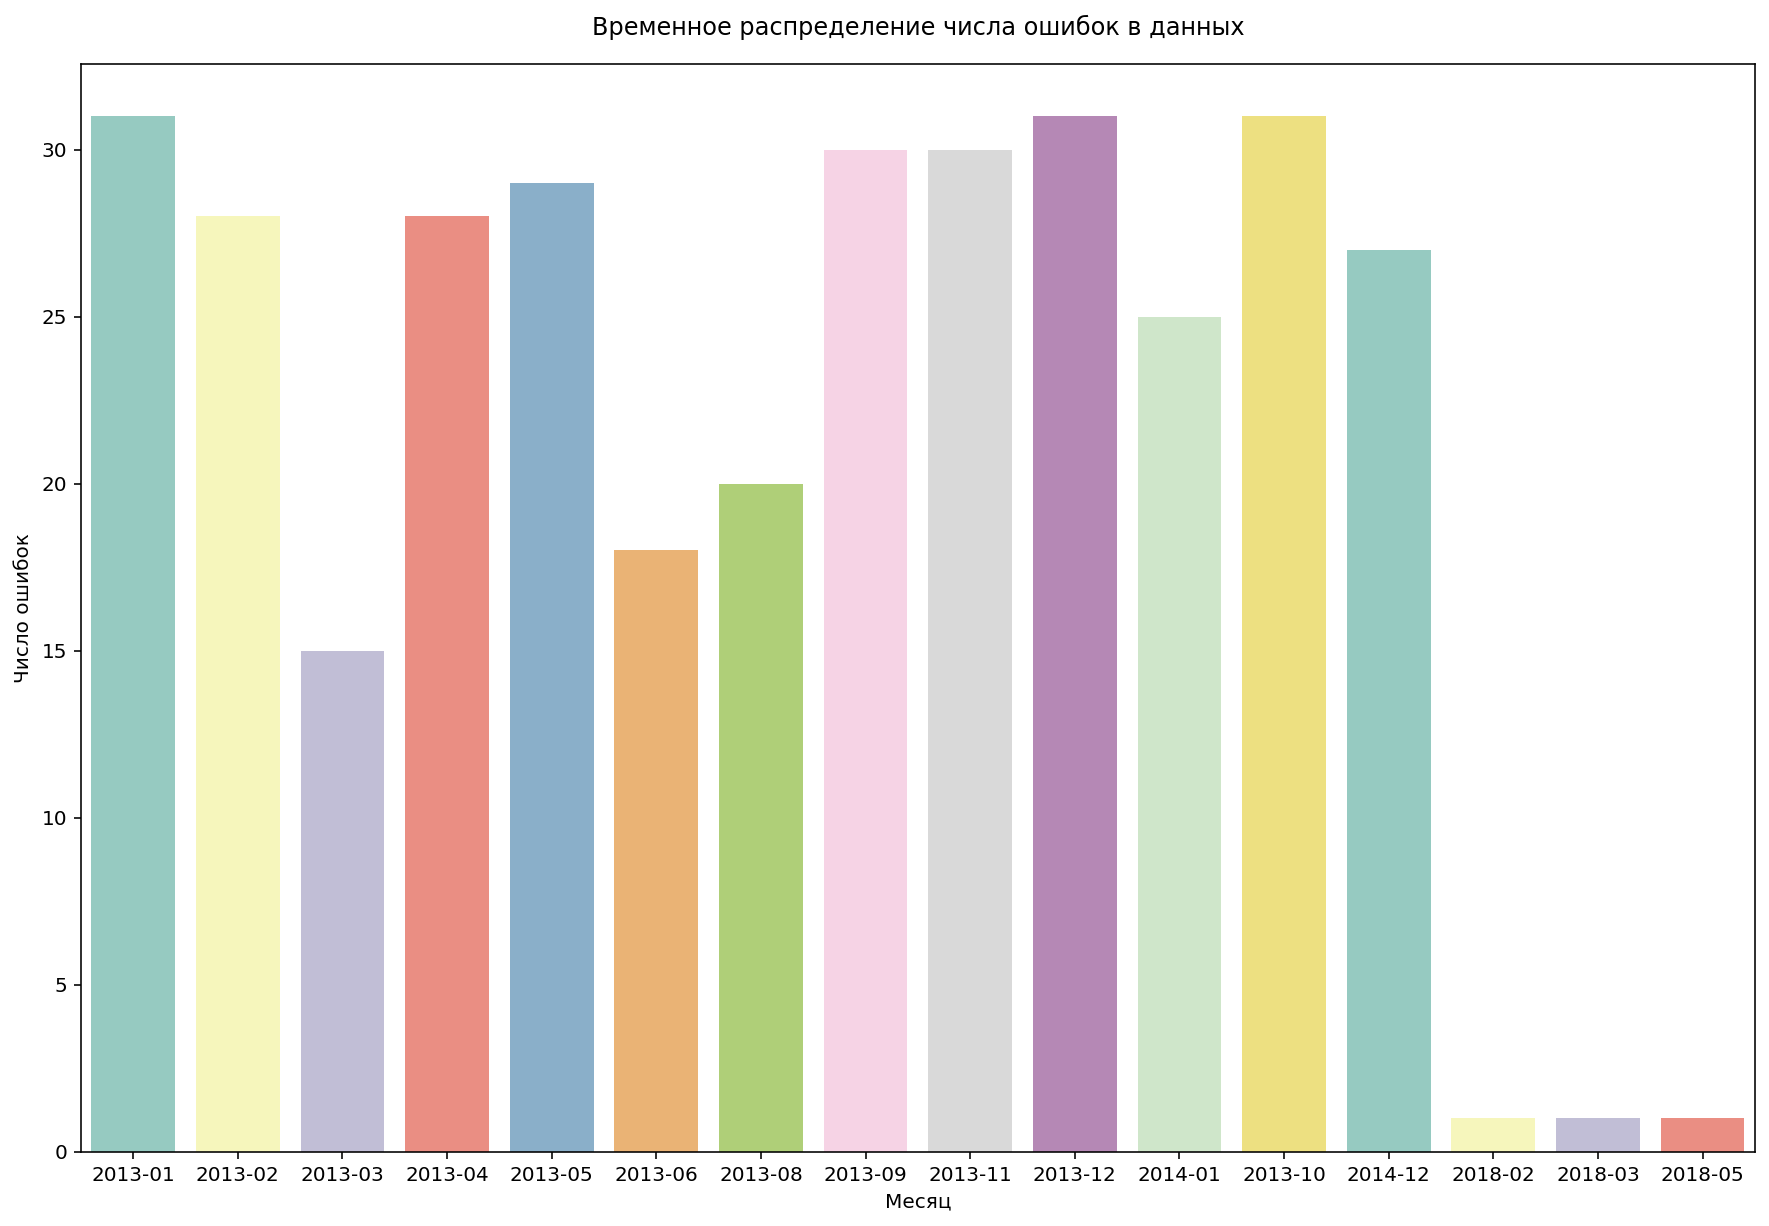

In [147]:
fig = plt.figure(figsize = (15, 10))

sns.countplot(d.iloc[errors].ReportDate.dt.to_period('M'), palette = 'Set3')

plt.title('Временное распределение числа ошибок в данных', pad = 15)
plt.xlabel('Месяц')
plt.ylabel('Число ошибок')

plt.show()

Период частого появления неточностей завершается к концу 2014 года. Вероятно, в последующие годы была налажена практика публикования корректных данных.

Наконец, можем создать отмасштабированное от 0 до 1 значение общего количества нарушений ПДД (`Infringements_norm`):

In [425]:
d['Infringements_norm'] = (d.TotalInfringementsAmount - d.TotalInfringementsAmount.min()) / (d.TotalInfringementsAmount.max() - d.TotalInfringementsAmount.min())

## Создание ячейки «пикселей»

In [8]:
test = d[(d.ReportDate.dt.year == 2016) & (d.ReportDate.dt.month == 6)][['ReportDate', 'TotalInfringementsAmount']]


In [9]:
test['TotalInfringementsAmount'] = (test.TotalInfringementsAmount - test.TotalInfringementsAmount.min()) / (test.TotalInfringementsAmount.max() - test.TotalInfringementsAmount.min())

In [10]:
test['weekday'] = test.ReportDate.dt.weekday 
test['week'] = test.ReportDate.dt.week - np.min(test.ReportDate.dt.week)
test.head()

,ReportDate,TotalInfringementsAmount,weekday,week
1218,2016-06-01,0.779505,2,0
1219,2016-06-02,0.471186,3,0
1220,2016-06-03,0.911130,4,0
1221,2016-06-04,0.303765,5,0
1222,2016-06-05,0.816421,6,0


In [85]:
palette = sns.color_palette("GnBu_d", 256)

def value_to_color(val):
    ind = int(val * (256 - 1)) # target index in the color palette
    return palette[ind]

fig, ax = plt.subplots(figsize = (10,7))

#ax.set(title='Пример ячейки визуализации с вариативным размером и цветом')
ax.scatter(x = test.weekday, y = test.week, s = test.TotalInfringementsAmount * 4000, marker = 's', c = test.TotalInfringementsAmount.apply(value_to_color))

ax.grid(False, 'major')
ax.grid(True, 'minor')

ax.set_xlim([-0.5, test.weekday.max() + 0.5]) 
ax.set_ylim([-0.5, test.week.max() + 0.5])

ax.set_xticks([], [])
ax.set_yticks([], [])

plt.gca().invert_yaxis()

plt.title('Пример ячейки визуализации с вариативным размером и цветом', pad = 15)


plt.show()

NameError: name 'test' is not defined

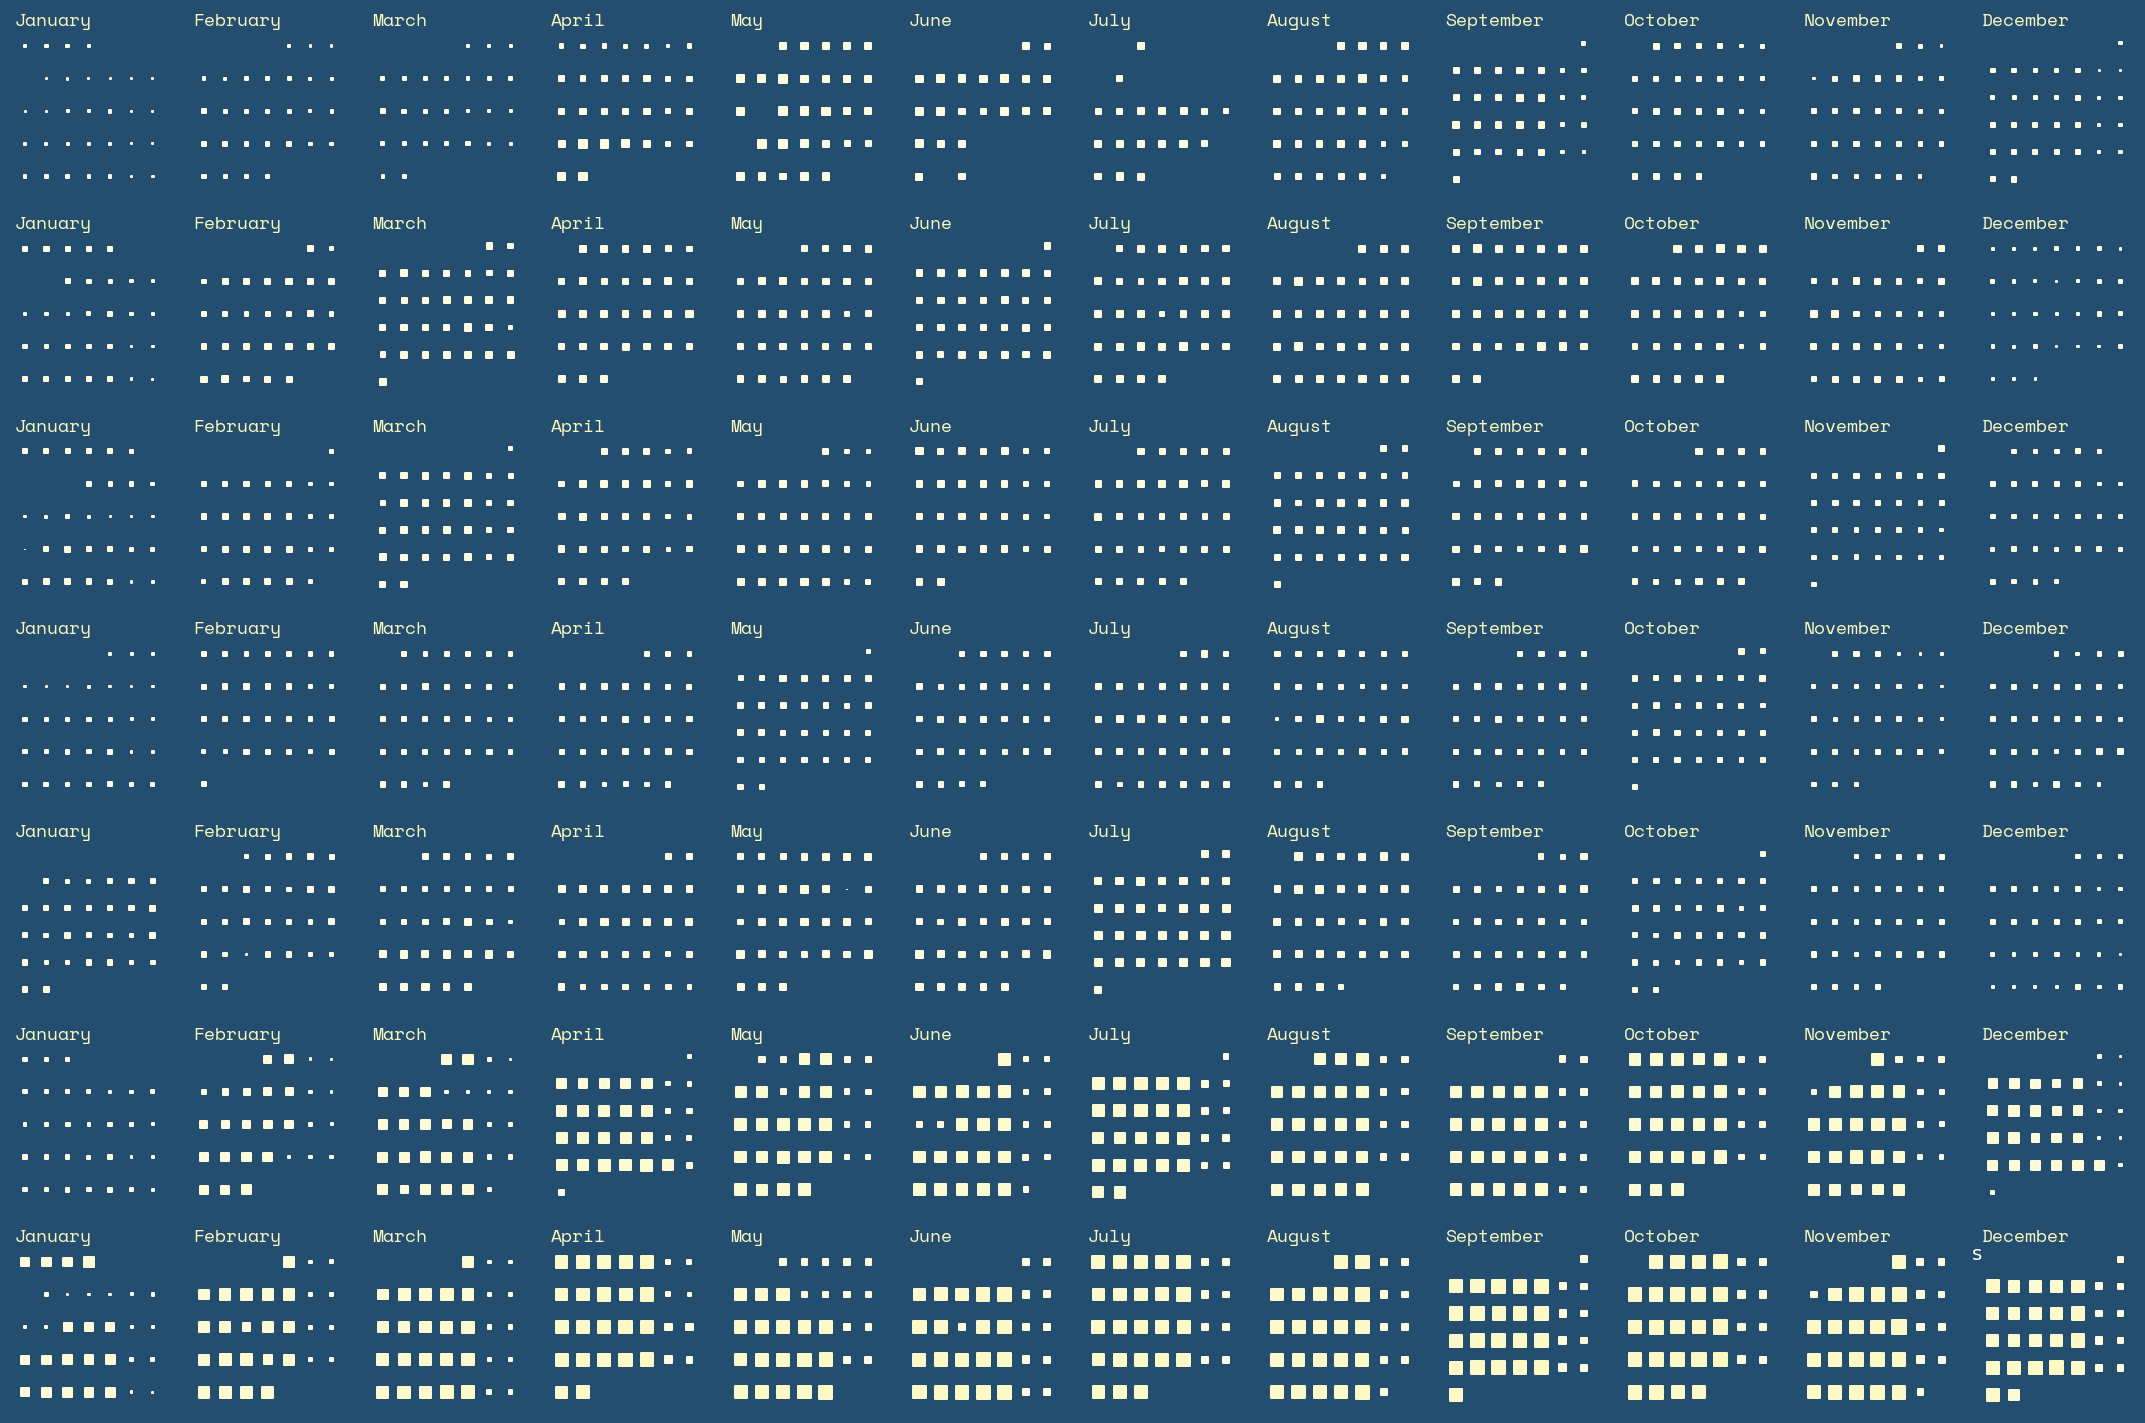

In [155]:
fig = plt.figure(figsize=(15, 10))
outer = fig.add_gridspec(7, 1, hspace = 3)


palette = sns.light_palette("#FBF8BE", 256)#sns.cubehelix_palette(256)#sns.color_palette("GnBu_d", 256)

def value_to_color(val):
    ind = int(val * (256 - 1)) # target index in the color palette
    return palette[ind]

for i, year in enumerate(d.ReportDate.dt.year.unique()):
    
    inner = outer[i].subgridspec(1, 12)

    for j in range(12):
        current = d[(d.ReportDate.dt.year == year) & (d.ReportDate.dt.month == j+1)][['ReportDate', 'Infringements_norm']]
        current['weekday'] = current.ReportDate.dt.weekday 
        if j+1 == 1:
            current['week'] = current.ReportDate.dt.week.replace({np.max(current.ReportDate.dt.week) : 0})

        elif j+1 == 12:
            week_fix = current.ReportDate.dt.week.replace({1 : np.max(current.ReportDate.dt.week) + 1})
            current['week'] = week_fix - np.min(week_fix)

        else:
            current['week'] = current.ReportDate.dt.week - np.min(current.ReportDate.dt.week)

        ax = fig.add_subplot(inner[j])
        ax.scatter(x = current.weekday, y = current.week, s = current.Infringements_norm * 50, marker = 's', c = current.Infringements_norm.apply(value_to_color))

        ax.grid(False, 'major')
        ax.grid(False, 'minor')

        ax.set_xticks([], [])
        ax.set_yticks([], [])

        ax.set_xlim([-0.5, current.weekday.max() + 0.5]) 
        ax.set_ylim([-0.5, current.week.max() + 0.5])

        #if i == 0:
        ax.set_title('{}'.format(current.ReportDate.dt.month_name().iloc[0]), loc = 'left', pad = 4, fontdict = {
            'fontsize': 9,
            'color' : "#FBF8BE",
            'fontfamily' : 'Space Mono',
            'fontweight' : 3,
            'verticalalignment': 'baseline'})
        
        ax.axis('off')
        plt.gca().invert_yaxis()
        fig.add_subplot(ax)


outer.tight_layout(fig)

ax.text(x = -1, y = 0, s = 's', color = 'w')
fig.set_facecolor('#234E70')

plt.box(False)
plt.show()

In [17]:
import matplotlib.font_manager as font_manager; font_manager._rebuild()

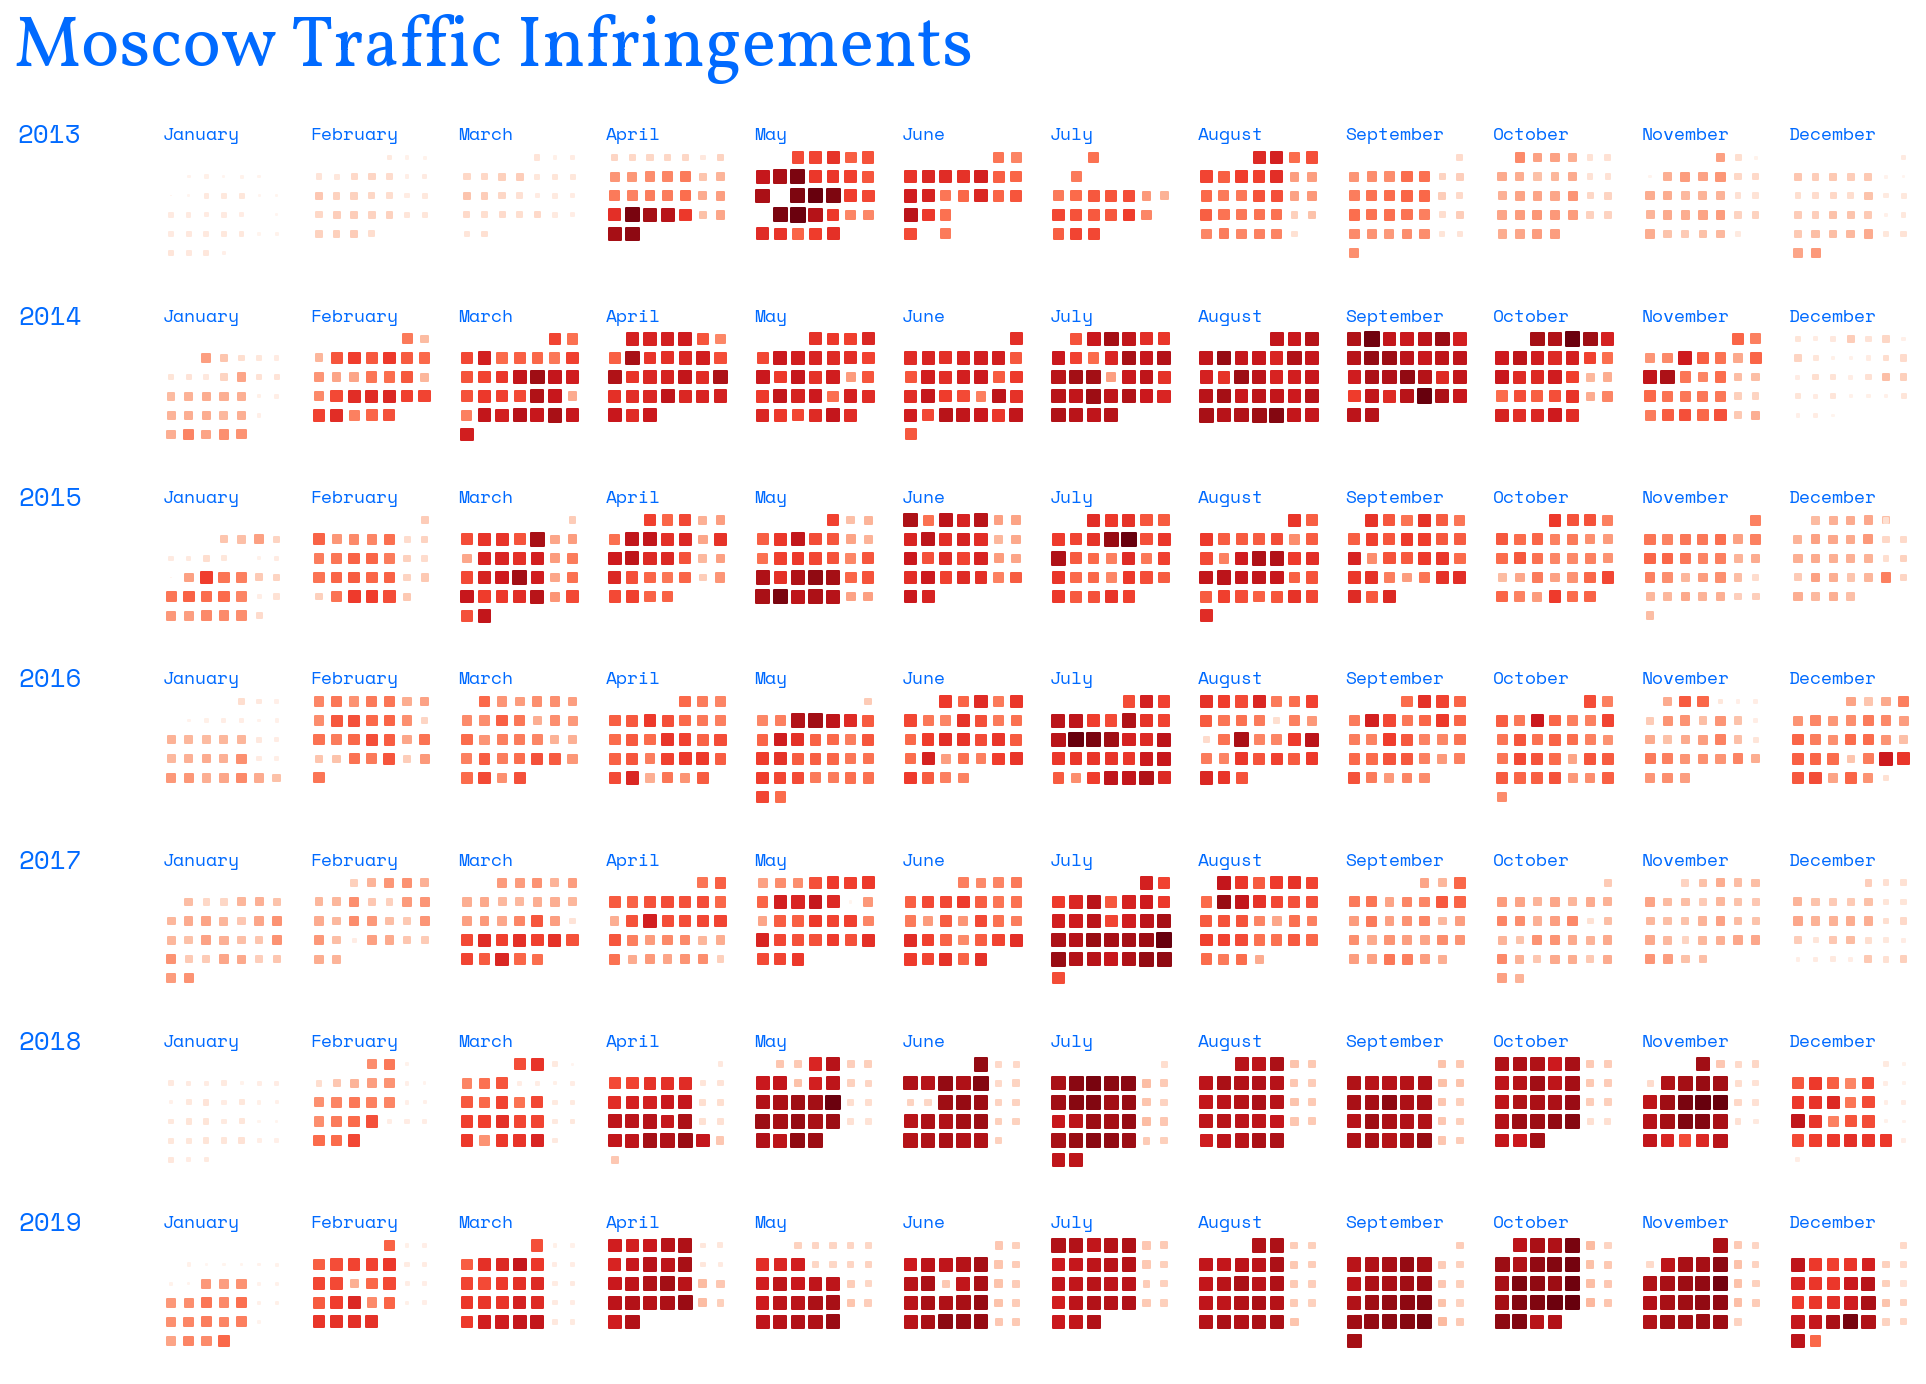

In [412]:
fig = plt.figure(figsize=(15, 10))
outer = fig.add_gridspec(7, 1, hspace = 5)

palette = sns.color_palette("Reds", 256)#sns.light_palette("#FF0000", 256)

def value_to_color(val):
    ind = int(val * (256 - 1)) # target index in the color palette
    return palette[ind]

for i, year in enumerate(d.ReportDate.dt.year.unique()):
    inner = outer[i].subgridspec(1, 13)
    data = d[d.ReportDate.dt.year == year]
    data['Infringements_norm_year'] = (data.TotalInfringementsAmount - data.TotalInfringementsAmount.min()) / (data.TotalInfringementsAmount.max() - data.TotalInfringementsAmount.min())


    ax0 = fig.add_subplot(inner[0])
    outer.tight_layout(fig, rect=[0, 0, 0.92, 0.92])

    ax0.set_title('{}'.format(year), loc = 'right', horizontalalignment = 'left', y = ax0.get_position().ymin, x = ax0.get_position().xmin,  fontdict = {
        'fontsize': 13,
        'color' : "#006AFF",
        'fontfamily' : 'Space Mono',
        'fontweight' : 3,
        'verticalalignment' : 'top'
        })

    ax0.grid(False, 'major')
    ax0.grid(False, 'minor')
    ax0.axis('off')

    ax0.set_xticks([], [])
    ax0.set_yticks([], [])


    for j in range(1, 13):
        current = data[data.ReportDate.dt.month == j][['ReportDate', 'Infringements_norm_year']]
        current['weekday'] = current.ReportDate.dt.weekday 
        if j == 1:
            if np.max(current.ReportDate.dt.week) > 40:
                current['week'] = current.ReportDate.dt.week.replace({np.max(current.ReportDate.dt.week) : 0})
            else:
                current['week'] = current.ReportDate.dt.week

        elif j == 12:
            week_fix = current.ReportDate.dt.week.replace({1 : np.max(current.ReportDate.dt.week) + 1})
            current['week'] = week_fix - np.min(week_fix)

        else:
            current['week'] = current.ReportDate.dt.week - np.min(current.ReportDate.dt.week)

        ax = fig.add_subplot(inner[j], sharey = ax0)
        ax.scatter(x = current.weekday, y = current.week, s = current.Infringements_norm_year * 45, marker = 's', c = current.Infringements_norm_year.apply(value_to_color))

        ax.grid(False, 'major')
        ax.grid(False, 'minor')
        ax.axis('off')

        ax.set_xticks([], [])
        ax.set_yticks([], [])

        ax.set_xlim([-0.5, current.weekday.max() + 0.5]) 
        ax.set_ylim([-0.5, 6 + 0.5])

        ax.set_title('{}'.format(current.ReportDate.dt.month_name().iloc[0]), pad = 2, loc = 'left', fontdict = {
            'fontsize': 9,
            'color' : "#006AFF",
            'fontfamily' : 'Space Mono',
            'fontweight' : 3,
            'verticalalignment': 'bottom'})
        
        plt.gca().invert_yaxis()
        #fig.add_subplot(ax)




fig.suptitle("Moscow Traffic Infringements", size = 36, horizontalalignment = 'left', x = ax0.get_position().xmin, fontdict = {
            'color' : "#006AFF",
            'fontfamily' : 'Vollkorn',
            'fontweight' : 3})


plt.box(False)
plt.show()

#plt.savefig('test.pdf', orientation='lanscape', format='pdf')

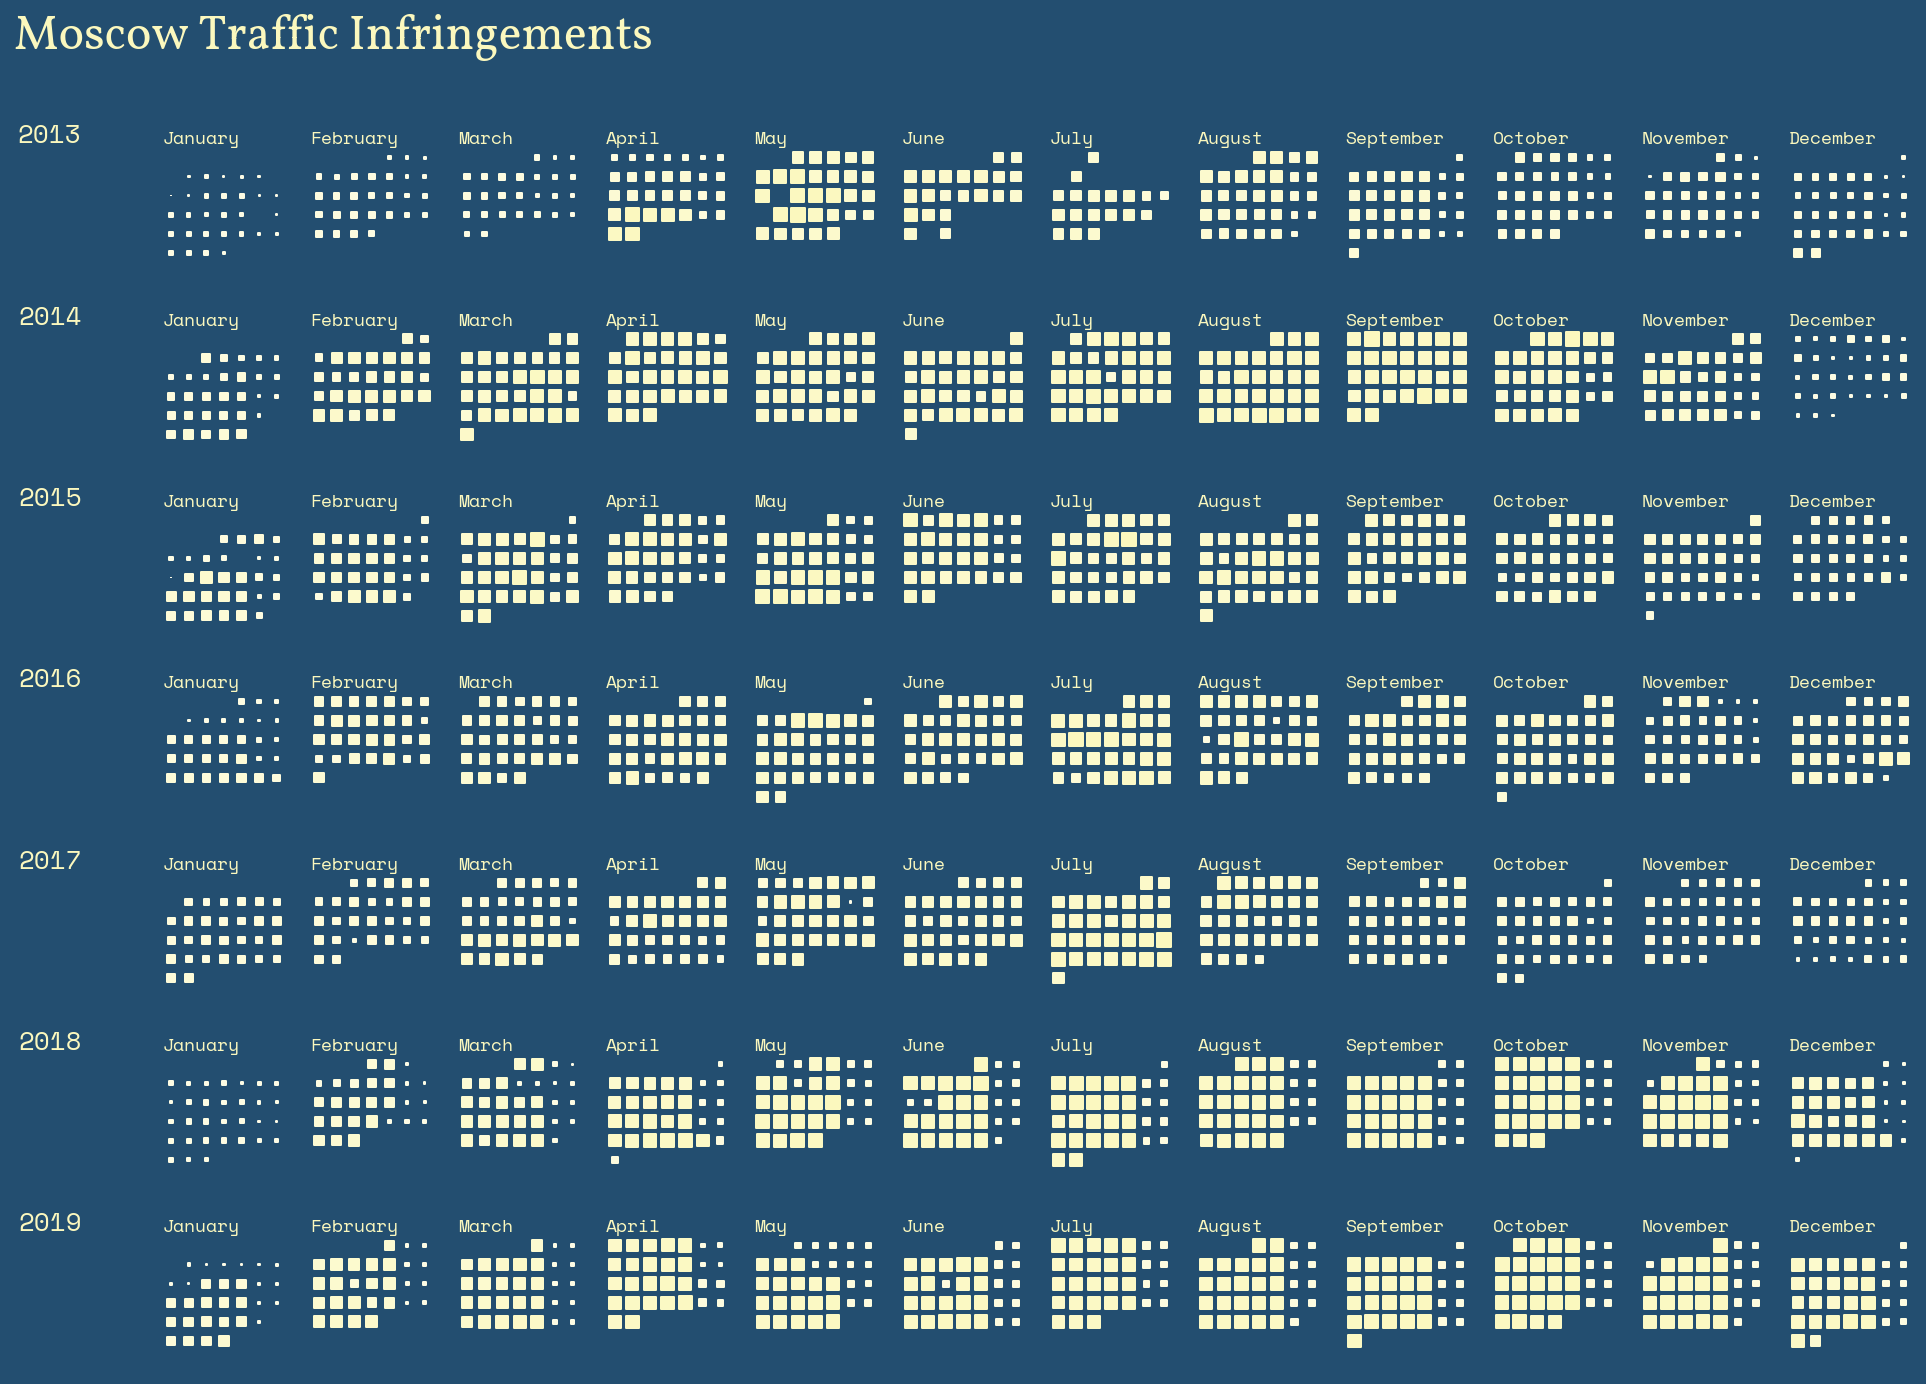

In [312]:
fig = plt.figure(figsize=(15, 10))
outer = fig.add_gridspec(7, 1, hspace = 5)

palette = sns.light_palette("#FBF8BE", 256)

def value_to_color(val):
    ind = int(val * (256 - 1)) # target index in the color palette
    return palette[ind]

for i, year in enumerate(d.ReportDate.dt.year.unique()):
    inner = outer[i].subgridspec(1, 13)
    data = d[d.ReportDate.dt.year == year]
    data['Infringements_norm_year'] = (data.TotalInfringementsAmount - data.TotalInfringementsAmount.min()) / (data.TotalInfringementsAmount.max() - data.TotalInfringementsAmount.min())


    ax0 = fig.add_subplot(inner[0])
    outer.tight_layout(fig, rect=[0, 0, 0.92, 0.92])

    ax0.set_title('{}'.format(year), loc = 'right', horizontalalignment = 'left', y = ax0.get_position().ymin, x = ax0.get_position().xmin,  fontdict = {
        'fontsize': 13,
        'color' : "#FBF8BE",
        'fontfamily' : 'Space Mono',
        'fontweight' : 3,
        'verticalalignment' : 'top'
        })

    ax0.grid(False, 'major')
    ax0.grid(False, 'minor')
    ax0.axis('off')

    ax0.set_xticks([], [])
    ax0.set_yticks([], [])


    for j in range(1, 13):
        current = data[data.ReportDate.dt.month == j][['ReportDate', 'Infringements_norm_year']]
        current['weekday'] = current.ReportDate.dt.weekday 
        if j == 1:
            if np.max(current.ReportDate.dt.week) > 40:
                current['week'] = current.ReportDate.dt.week.replace({np.max(current.ReportDate.dt.week) : 0})
            else:
                current['week'] = current.ReportDate.dt.week

        elif j == 12:
            week_fix = current.ReportDate.dt.week.replace({1 : np.max(current.ReportDate.dt.week) + 1})
            current['week'] = week_fix - np.min(week_fix)

        else:
            current['week'] = current.ReportDate.dt.week - np.min(current.ReportDate.dt.week)

        ax = fig.add_subplot(inner[j], sharey = ax0)
        ax.scatter(x = current.weekday, y = current.week, s = current.Infringements_norm_year * 45, marker = 's', c = current.Infringements_norm_year.apply(value_to_color))

        ax.grid(False, 'major')
        ax.grid(False, 'minor')
        ax.axis('off')

        ax.set_xticks([], [])
        ax.set_yticks([], [])

        ax.set_xlim([-0.5, current.weekday.max() + 0.5]) 
        ax.set_ylim([-0.5, 6 + 0.5])

        ax.set_title('{}'.format(current.ReportDate.dt.month_name().iloc[0]), pad = 2, loc = 'left', fontdict = {
            'fontsize': 9,
            'color' : "#FBF8BE",
            'fontfamily' : 'Space Mono',
            'fontweight' : 3,
            'verticalalignment': 'bottom'})
        
        plt.gca().invert_yaxis()
        #fig.add_subplot(ax)




fig.suptitle("Moscow Traffic Infringements", size = 24, horizontalalignment = 'left', x = ax0.get_position().xmin, fontdict = {
            'color' : "#FBF8BE",
            'fontfamily' : 'Vollkorn',
            'fontweight' : 3})

fig.set_facecolor('#234E70')

plt.box(False)
plt.show()

#plt.savefig('test.pdf', orientation='lanscape', format='pdf')

In [16]:
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [176]:
fig.subplotpars.left

0.125

In [302]:
ax0.get_position().ymin

0.038611111111111374

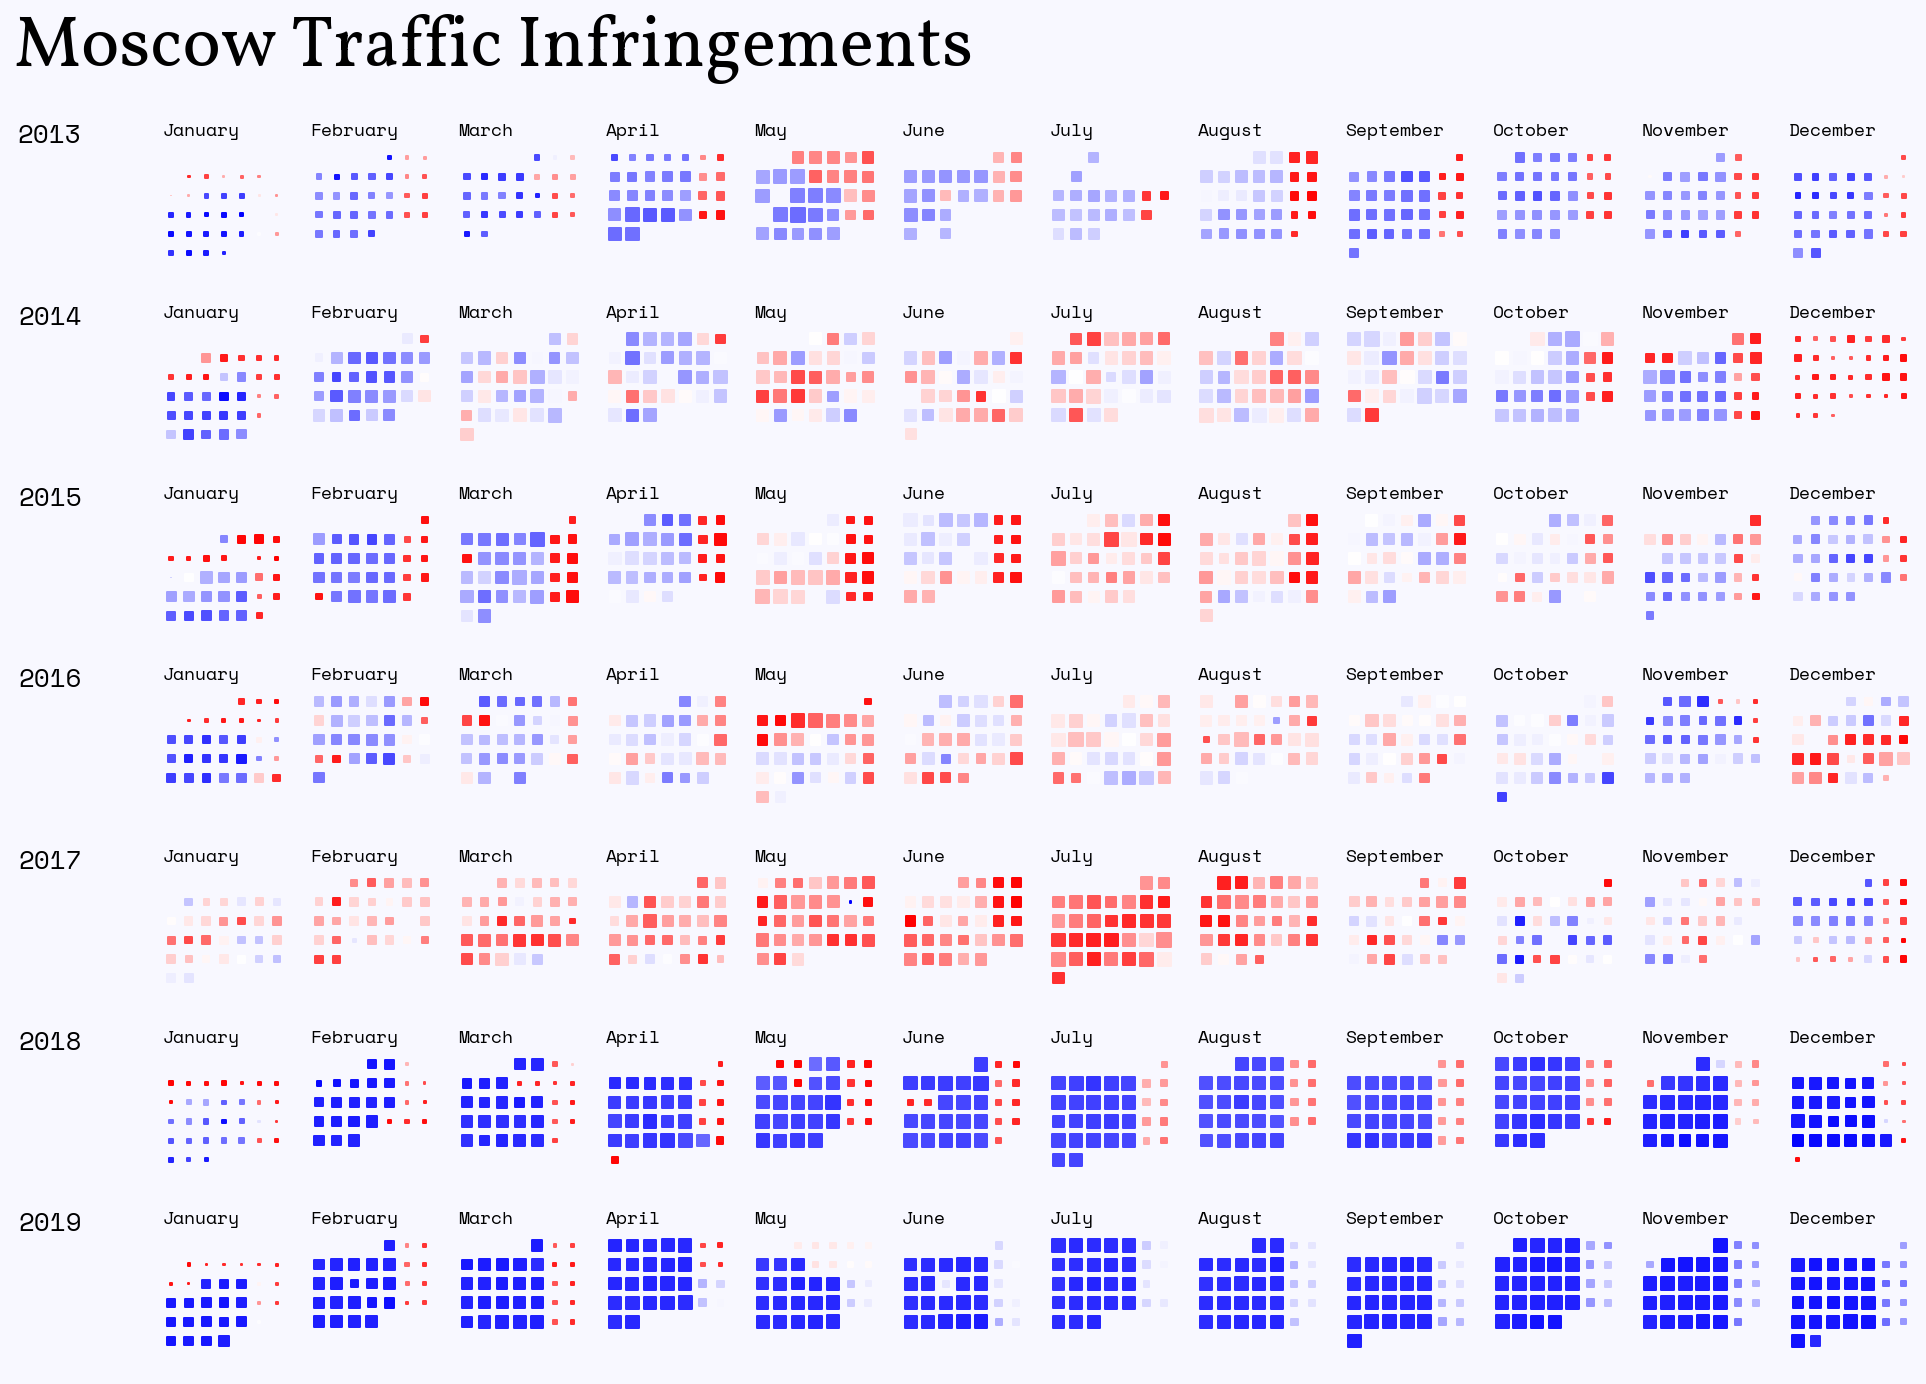

In [409]:
fig = plt.figure(figsize=(15, 10))
outer = fig.add_gridspec(7, 1, hspace = 5)

palette = sns.color_palette("bwr", 256)#sns.light_palette("#FF0000", 256)

def value_to_color(val):
    ind = int(val * (256 - 1)) # target index in the color palette
    return palette[ind]

for i, year in enumerate(d.ReportDate.dt.year.unique()):
    inner = outer[i].subgridspec(1, 13)
    data = d[d.ReportDate.dt.year == year]
    data['Infringements_norm_year'] = (data.TotalInfringementsAmount - data.TotalInfringementsAmount.min()) / (data.TotalInfringementsAmount.max() - data.TotalInfringementsAmount.min())
    data['SpeedLimitInfringementsAmount_ratio'] = (data.SpeedLimitInfringementsAmount / data.TotalInfringementsAmount).fillna(0)


    ax0 = fig.add_subplot(inner[0])
    outer.tight_layout(fig, rect=[0, 0, 0.92, 0.92])

    ax0.set_title('{}'.format(year), loc = 'right', horizontalalignment = 'left', y = ax0.get_position().ymin, x = ax0.get_position().xmin,  fontdict = {
        'fontsize': 13,
        'color' : "#000000",
        'fontfamily' : 'Space Mono',
        'fontweight' : 3,
        'verticalalignment' : 'top'
        })

    ax0.grid(False, 'major')
    ax0.grid(False, 'minor')
    ax0.axis('off')

    ax0.set_xticks([], [])
    ax0.set_yticks([], [])


    for j in range(1, 13):
        current = data[data.ReportDate.dt.month == j][['ReportDate', 'Infringements_norm_year', 'SpeedLimitInfringementsAmount_ratio']]
        current['weekday'] = current.ReportDate.dt.weekday 
        if j == 1:
            if np.max(current.ReportDate.dt.week) > 40:
                current['week'] = current.ReportDate.dt.week.replace({np.max(current.ReportDate.dt.week) : 0})
            else:
                current['week'] = current.ReportDate.dt.week

        elif j == 12:
            week_fix = current.ReportDate.dt.week.replace({1 : np.max(current.ReportDate.dt.week) + 1})
            current['week'] = week_fix - np.min(week_fix)

        else:
            current['week'] = current.ReportDate.dt.week - np.min(current.ReportDate.dt.week)

        ax = fig.add_subplot(inner[j], sharey = ax0)
        ax.scatter(x = current.weekday, y = current.week, s = current.Infringements_norm_year * 45, marker = 's', c = current.SpeedLimitInfringementsAmount_ratio.apply(value_to_color))

        ax.grid(False, 'major')
        ax.grid(False, 'minor')
        ax.axis('off')

        ax.set_xticks([], [])
        ax.set_yticks([], [])

        ax.set_xlim([-0.5, current.weekday.max() + 0.5]) 
        ax.set_ylim([-0.5, 6 + 0.5])

        ax.set_title('{}'.format(current.ReportDate.dt.month_name().iloc[0]), pad = 2, loc = 'left', fontdict = {
            'fontsize': 9,
            'color' : "#000000",
            'fontfamily' : 'Space Mono',
            'fontweight' : 3,
            'verticalalignment': 'bottom'})
        
        plt.gca().invert_yaxis()
        #fig.add_subplot(ax)




fig.suptitle("Moscow Traffic Infringements", size = 36, horizontalalignment = 'left', x = ax0.get_position().xmin, fontdict = {
            'color' : "#000000",
            'fontfamily' : 'Vollkorn',
            'fontweight' : 3})

fig.set_facecolor('#F8F8FF')
plt.box(False)
plt.show()

#plt.savefig('test.pdf', orientation='lanscape', format='pdf', facecolor='#F8F8FF')